In [632]:
import pandas as pd

In [633]:
path = "COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv"
data = pd.read_csv(path)

In [637]:
data_t = data.T
data_t.columns = data_t.iloc[1, :].astype(str) + '_' +  data_t.iloc[0, :].astype(str)
data_t = data_t.iloc[4:]
data_t = data_t.reset_index()
data_t['date'] = pd.to_datetime(data_t['index'])
data_t.columns = data_t.columns.str.replace(" ","_")
data_t.columns = data_t.columns.str.replace(",","_")
data_t = data_t.drop(['index', ], axis=1)
data_t = data_t.set_index('date')

In [646]:
data_china = data[data['Country/Region'] == 'Mainland China'].T
data_china = data_china.sum(axis=1)
data_china = data_china.iloc[4:]
data_china = data_china.rename('China_total')

In [650]:
data_all= pd.concat([data_t, data_china], axis=1)
melted = pd.melt(data_all)
size = len(melted['variable'].unique())
index = ([data_all.index.to_list()] * size)
flat_index = [item for sublist in index for item in sublist]
full_df = pd.concat([melted, pd.DataFrame(flat_index, columns=['date'])], axis=1)
full_df.to_csv('corona_confirmed_formated.csv', index=False)
full_df.head()

## Automaticaly fit sigmoid

In [427]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
sns.set()


In [664]:
non_china_non_cruise = ['Thailand_nan', 'Japan_nan',
       'South_Korea_nan', 'Taiwan_Taiwan', 'US_Seattle__WA',
       'US_Chicago__IL', 'US_Tempe__AZ', 'Macau_Macau',
       'Hong_Kong_Hong_Kong', 'Singapore_nan', 'Vietnam_nan',
       'France_nan', 'Nepal_nan', 'Malaysia_nan', 'Canada_Toronto__ON',
       'Canada_British_Columbia', 'US_Orange__CA', 'US_Los_Angeles__CA',
       'Australia_New_South_Wales', 'Australia_Victoria',
       'Australia_Queensland', 'Cambodia_nan', 'Sri_Lanka_nan',
       'Germany_nan', 'Finland_nan', 'United_Arab_Emirates_nan',
       'Philippines_nan', 'India_nan', 'Canada_London__ON', 'Italy_nan',
       'UK_nan', 'Russia_nan', 'Sweden_nan', 'US_Santa_Clara__CA',
       'Spain_nan', 'Australia_South_Australia', 'US_Boston__MA',
       'US_San_Benito__CA', 'Belgium_nan', 'US_Madison__WI',
       'US_San_Diego_County__CA',
       'US_San_Antonio__TX', 'Egypt_nan', 'US_Omaha__NE']

non_hubei = ['Mainland_China_Anhui', 'Mainland_China_Beijing',
       'Mainland_China_Chongqing', 'Mainland_China_Fujian',
       'Mainland_China_Gansu', 'Mainland_China_Guangdong',
       'Mainland_China_Guangxi', 'Mainland_China_Guizhou',
       'Mainland_China_Hainan', 'Mainland_China_Hebei',
       'Mainland_China_Heilongjiang', 'Mainland_China_Henan',
        'Mainland_China_Hunan',
       'Mainland_China_Inner_Mongolia', 'Mainland_China_Jiangsu',
       'Mainland_China_Jiangxi', 'Mainland_China_Jilin',
       'Mainland_China_Liaoning', 'Mainland_China_Ningxia',
       'Mainland_China_Qinghai', 'Mainland_China_Shaanxi',
       'Mainland_China_Shandong', 'Mainland_China_Shanghai',
       'Mainland_China_Shanxi', 'Mainland_China_Sichuan',
       'Mainland_China_Tianjin', 'Mainland_China_Tibet',
       'Mainland_China_Xinjiang', 'Mainland_China_Yunnan',
       'Mainland_China_Zhejiang', ]

hubei = ['Mainland_China_Hubei']

def get_X_vector(df, columns):
    X = full_df[full_df['variable'].isin(columns)]
    X = X.set_index('date')
    X = X.resample('D').sum()['value']
    return X.values

X_non_hub = get_X_vector(full_df, non_hubei)
X_non_china_non_cruise = get_X_vector(full_df, non_china_non_cruise)
X_hubei = get_X_vector(full_df, hubei)

In [689]:
import numpy, scipy, matplotlib
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.optimize import differential_evolution
import warnings

def optimize_fit_and_plot(xData, yData, number_of_days, title, test_days=1):

    def sigmoid(x, amplitude, x0, k):
        return amplitude * 1.0/(1.0+numpy.exp(-x0*(x-k)))


    # function for genetic algorithm to minimize (sum of squared error)
    def sumOfSquaredError(parameterTuple):
        warnings.filterwarnings("ignore") # do not print warnings by genetic algorithm
        val = sigmoid(xData, *parameterTuple)
        return numpy.sum((yData - val) ** 2.0)


    def generate_Initial_Parameters():
        # min and max used for bounds
        maxX = max(xData)
        minX = min(xData)
        maxY = max(yData)
        minY = min(yData)

        parameterBounds = []
        parameterBounds.append([minY, maxY]) # search bounds for amplitude
        parameterBounds.append([minX, maxX]) # search bounds for x0
        parameterBounds.append([minX, maxX]) # search bounds for k

        # "seed" the numpy random number generator for repeatable results
        result = differential_evolution(sumOfSquaredError, parameterBounds, seed=3)
        return result.x

    # by default, differential_evolution completes by calling curve_fit() using parameter bounds
    geneticParameters = generate_Initial_Parameters()

    # now call curve_fit without passing bounds from the genetic algorithm,
    # just in case the best fit parameters are aoutside those bounds
    fittedParameters, pcov = curve_fit(sigmoid, xData[:-test_days], yData[:-test_days], geneticParameters)
    print('Fitted parameters:', fittedParameters)
    print()

    modelPredictions = sigmoid(xData, *fittedParameters) 

    absError = modelPredictions - yData

    SE = numpy.square(absError) # squared errors
    MSE = numpy.mean(SE) # mean squared errors
    RMSE = numpy.sqrt(MSE) # Root Mean Squared Error, RMSE
    Rsquared = 1.0 - (numpy.var(absError) / numpy.var(yData))

    print()
    print('RMSE:', RMSE)
    print('R-squared:', Rsquared)

    print()


    ##########################################################
    # graphics output section
    def ModelAndScatterPlot(graphWidth, graphHeight, number_of_days):
        xModel = numpy.linspace(0, number_of_days, number_of_days+1)
        
        yModel = sigmoid(xModel, *fittedParameters)
        index_sig = pd.date_range('2020-01-22', periods=number_of_days+1)
        model = pd.Series(yModel)
        model.index = index_sig


        # now the model as a line plot
        #axes.plot(xModel, yModel)
        ax = model.plot(figsize=(20,10), linewidth=7)

        # first the raw data as a scatter plot
        actual_cases = pd.Series(yData[:-test_days])
        index_actual = pd.date_range('2020-01-22', periods=len(yData[:-test_days]))
        actual_cases.index = index_actual
        actual_cases.plot(style='o', ms=12)
        
        non_trained_cases = pd.Series(yData[-test_days:])
        start_non_trained = (index_actual[-1] + pd.Timedelta(1, 'D')).strftime("%Y-%m-%d")
        
        index_non_trained = pd.date_range(start_non_trained, periods=test_days)
        non_trained_cases.index = index_non_trained
        non_trained_cases.plot(style='*', ms=20)
        

        #ax.set_xlabel('date', fontsize=200) # X axis data label
        ax.set_ylabel('confirmed cases', fontsize=30) # Y axis data label
        ax.legend(['simulation', 'real cases', 'non trained real cases'], prop={'size': 25})
        ax.set_title(title, fontsize=20)

        ax.xaxis.set_minor_locator(dates.MonthLocator(interval=5))
        ax.xaxis.set_minor_formatter(dates.DateFormatter(''))
        # Set major ticks with month names
        ax.xaxis.set_major_locator(dates.DayLocator(interval=2))
        ax.xaxis.set_major_formatter(dates.DateFormatter('\n%d %b'))
        ax.tick_params(axis='x', labelsize=20)
        ax.tick_params(axis='y', labelsize=20)
        plt.xticks(rotation=70)

        plt.show()
        plt.close('all') # clean up after using pyplot

        return ax

    graphWidth = 800
    graphHeight = 600
    plot = ModelAndScatterPlot(graphWidth, graphHeight, number_of_days)

Fitted parameters: [8.64705552e+04 1.87223645e-01 2.21321127e+01]


RMSE: 2737.4661018202505
R-squared: 0.9846464899794695



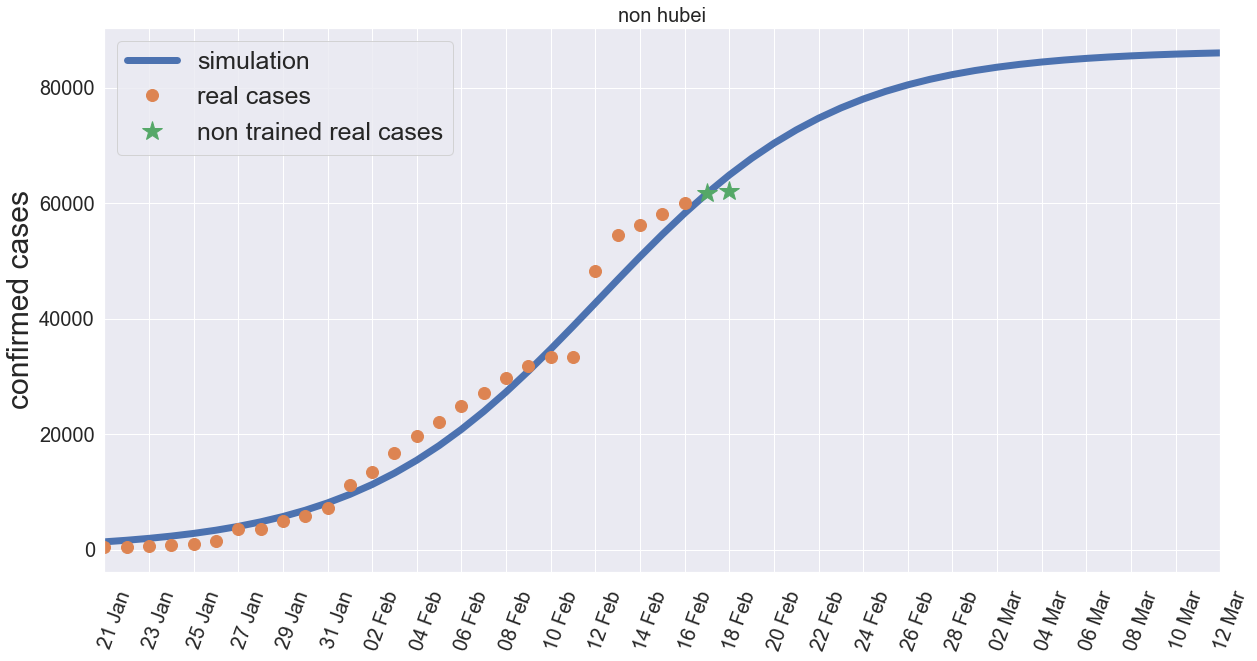

In [680]:
yData = X_hubei
xData = np.linspace(0, len(yData),len(yData+1))

optimize_fit_and_plot(xData, yData, number_of_days=50, title='non hubei', test_days=2)

Fitted parameters: [4.65635674e+02 1.79322750e-01 1.48112823e+01]


RMSE: 16.0309218852504
R-squared: 0.9877954268891551



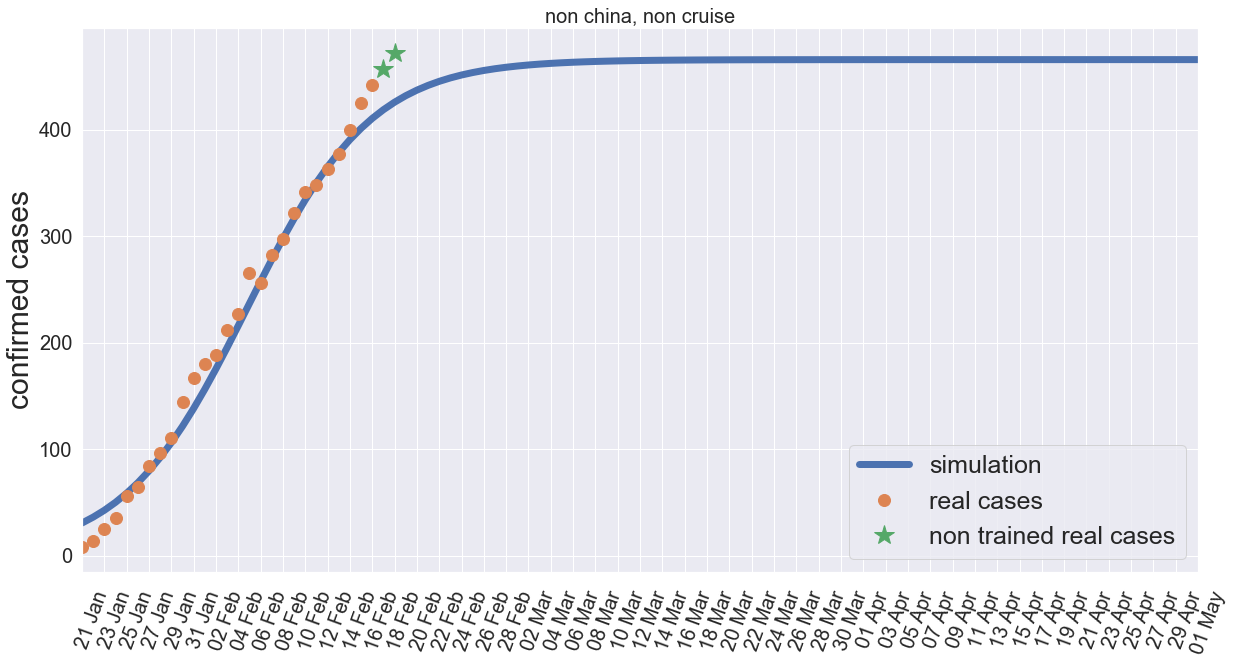

In [690]:
yData = X_non_china_non_cruise
xData = np.linspace(0, len(yData),len(yData+1))

optimize_fit_and_plot(xData, yData, number_of_days=100, title = 'non china, non cruise', test_days=2)

Fitted parameters: [4.65635674e+02 1.79322750e-01 1.48112823e+01]


RMSE: 16.0309218852504
R-squared: 0.9877954268891551



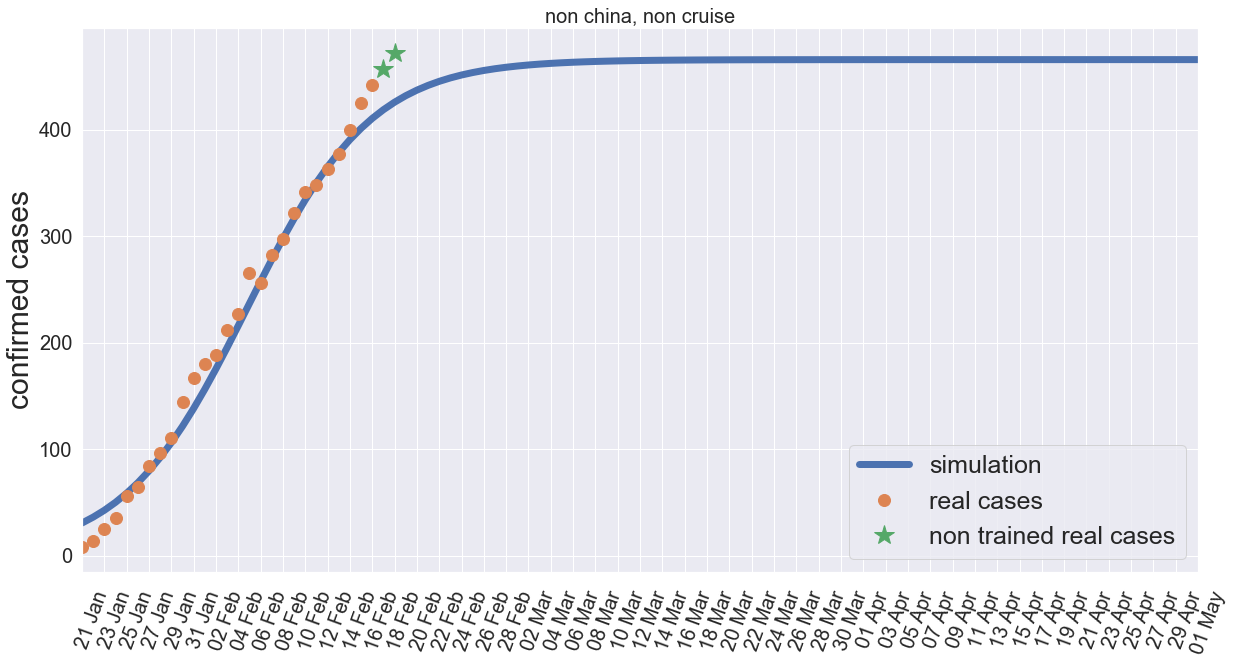

In [671]:
yData = X_non_china_non_cruise
xData = np.linspace(0, len(yData),len(yData+1))

optimize_fit_and_plot(xData, yData, number_of_days=100, title = 'non china, non cruise', test_days=2)

Fitted parameters: [6.24686420e+02 3.03565608e-01 2.53562960e+01]


RMSE: 28.44104971794615
R-squared: 0.9637056420939158



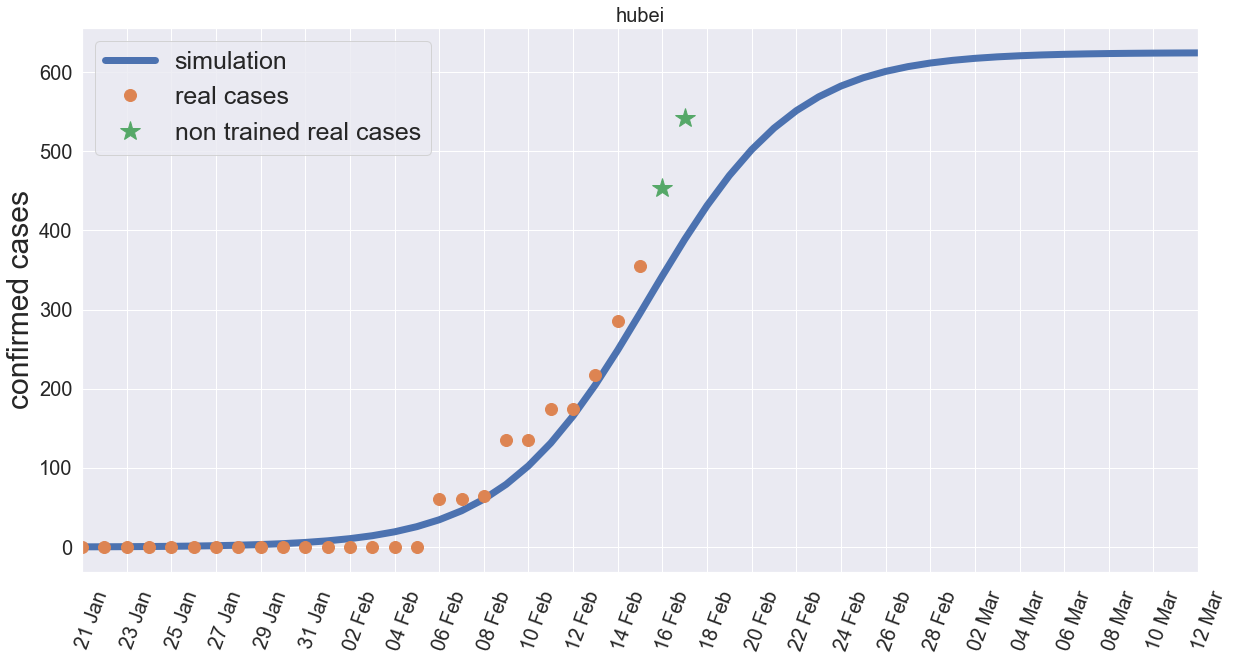

In [676]:
yData = X_hub.values
xData = np.linspace(0, len(yData),len(yData+1))

optimize_fit_and_plot(xData, yData, number_of_days=50, title = 'hubei', test_days=2)

Fitted parameters: [6.24693894e+02 3.14808224e-01 2.44507814e+01]


RMSE: 28.4406366450129
R-squared: 0.9637066910124792



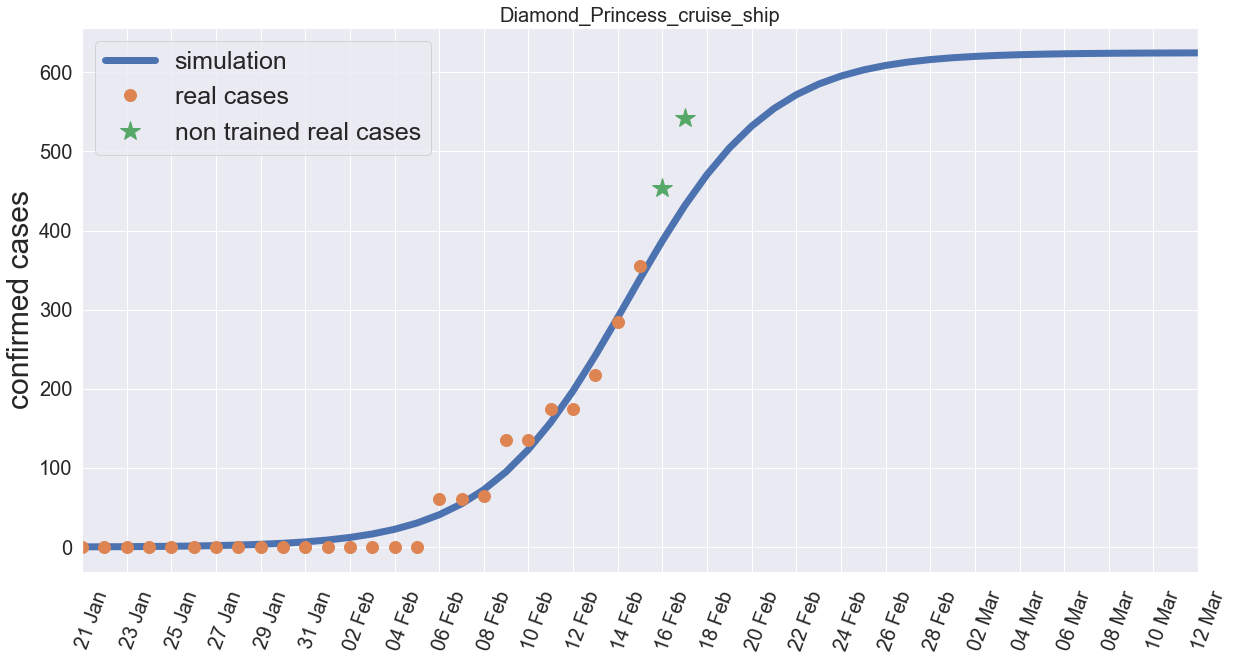

In [631]:
X_hub = full_df[full_df['variable'] == 'Others_Diamond_Princess_cruise_ship']
X_hub = X_hub.set_index('date')
X_hub = X_hub.resample('D').sum()['value']

yData = X_hub.values
xData = np.linspace(0, 27,28)

optimize_fit_and_plot(xData, yData, number_of_days=50, title = 'Diamond_Princess_cruise_ship', test_days=2)


## Population region china

In [56]:
pop = pd.read_csv('population_china.csv', sep='	', thousands=',')

In [57]:
pop

,Region,2018,2017,2016,2015,2014,2013,2012,2011,2010,2009
0,Beijing,30319.98,28014.94,25669.13,23014.59,21330.83,19800.81,17879.40,16251.93,14113.58,12153.03
1,Tianjin,18809.64,18549.19,17885.39,16538.19,15726.93,14442.01,12893.88,11307.28,9224.46,7521.85
2,Hebei,36010.27,34016.32,32070.45,29806.11,29421.15,28442.95,26575.01,24515.76,20394.26,17235.48
3,Shanxi,16818.11,15528.42,13050.41,12766.49,12761.49,12665.25,12112.83,11237.55,9200.86,7358.31
4,Inner Mongolia,17289.22,16096.21,18128.10,17831.51,17770.19,16916.50,15880.58,14359.88,11672.00,9740.25
5,Liaoning,25315.35,23409.24,22246.90,28669.02,28626.58,27213.22,24846.43,22226.70,18457.27,15212.49
6,Jilin,15074.62,14944.53,14776.80,14063.13,13803.14,13046.40,11939.24,10568.83,8667.58,7278.75
7,Heilongjiang,16361.62,15902.68,15386.09,15083.67,15039.38,14454.91,13691.58,12582.00,10368.60,8587.00
8,Shanghai,32679.87,30632.99,28178.65,25123.45,23567.70,21818.15,20181.72,19195.69,17165.98,15046.45
9,Jiangsu,92595.40,85869.76,77388.28,70116.38,65088.32,59753.37,54058.22,49110.27,41425.48,34457.30


In [58]:
pop = pop[['Region', '2018']]
pop.columns = ['Region', 'population']

In [61]:
china = data_t.columns[data_t.columns.str.startswith('Mainland_China')]
list_of_region = china.str.split('_', expand=True).to_list()
regions = [i[2] for i in list_of_region]
china_data = data_t[china]
regions[14] = 'Inner Mongolia'
china_data.columns = regions
for region in regions:
    china_data[region] = china_data[region]/ pop[pop['Region'] == region]['population'].values[0]

china_data = china_data.astype(float)

In [83]:
df = china_data

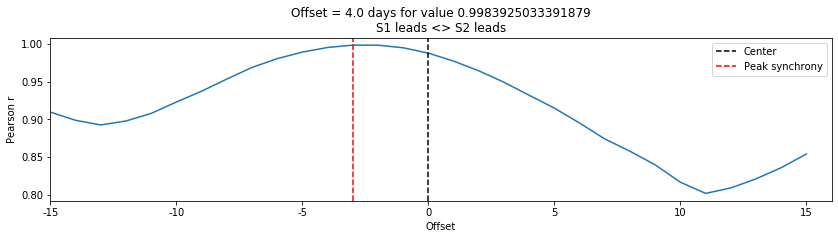

In [94]:
def crosscorr(datax, datay, lag=0, wrap=False):
    """ Lag-N cross correlation. 
    Shifted data filled with NaNs 
    
    Parameters
    ----------
    lag : int, default 0
    datax, datay : pandas.Series objects of equal length

    Returns
    ----------
    crosscorr : float
    """
    if wrap:
        shiftedy = datay.shift(lag)
        shiftedy.iloc[:lag] = datay.iloc[-lag:].values
        return datax.corr(shiftedy)
    else: 
        return datax.corr(datay.shift(lag))

d1 = df['Jiangxi']
d2 = df['Heilongjiang']
day_range = 15
rs = [crosscorr(d1,d2, lag) for lag in range(-int(day_range),int(day_range+1))]
offset = np.ceil(len(rs)/2)-np.argmax(rs)
f,ax=plt.subplots(figsize=(14,3))
ax.plot(rs)
ax.axvline(np.floor(len(rs)/2),color='k',linestyle='--',label='Center')
ax.axvline(np.argmax(rs),color='r',linestyle='--',label='Peak synchrony')
ax.set(title=f'Offset = {offset} days for value {np.max(rs)}\nS1 leads <> S2 leads',
       #ylim=[.1,.31],
       xlim=[0,31], xlabel='Offset',ylabel='Pearson r')
ax.set_xticks([0, 5, 10, 15, 20, 25, 30])
ax.set_xticklabels([-15, -10, -5, 0, 5, 10, 15]);
plt.legend()

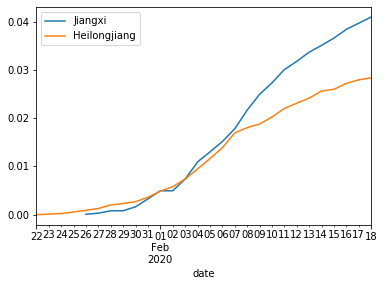

In [129]:
d1.shift(4).plot(legend=d1.name)
d2.plot(legend=d2.name)

In [404]:
## Others

# Manual fit of sigmoid